## Network measures

### Local structures

**Indegree**
This is mostly a function of how Wikipedians revised the document and should largely be uniform across pages. The large values are likely pages with 'lists' of links.

**Outdegree**
This is 1st-order measure of an idea's influence.

### Mesoscale structures

**Clustering**
These look equally clustered among the topics.

**Centrality**
This reveals the distribution of sources of ideas within a field.

**Path lengths**

**Rich-club coefficient**

**Modularity**

**Controllability**
This is an nth-order measure of influence.

**Observability**
This is an nth-order measure of the inverse of influence.

**Coreness**
It seems that the more focused a topic is on a subtopic, the stronger the coreness. For example, genetics is heavily focused on DNA, and so it has high coreness. At the same time, in the field of economics, the concept of "economics" has high degree. Yet, it has low coreness because the field itself is heterogeneous, with major subfields such as "macroeconomics" and "microeconomics".

**Characteristic path length**
I'm not sure what path length reveals. Perhaps it is a measure of the heterogeneity in research? It describes how far one idea is to another, topologically. Cognitive science and earth science have ideas that are far away.

In [1]:
%reload_ext autoreload
%autoreload 2
import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..', 'module'))

### Load networks

In [2]:
topics = ['anatomy', 'biochemistry', 'cognitive science', 'evolutionary biology',
          'genetics', 'immunology', 'molecular biology', 'chemistry',
          'biophysics', 'energy', 'optics', 'earth science', 'geology',
          'meteorology', 'philosophy of language', 'philosophy of law', 
          'philosophy of mind', 'philosophy of science', 'economics',
          'accounting', 'education', 'linguistics', 'law', 'psychology', 'sociology',
          'electronics', 'software engineering', 'robotics']#, 'physics']

In [3]:
import wiki

path_saved = '/Users/harangju/Developer/data/wiki/graphs/dated/'
networks = {}
for topic in topics:
    print(topic, end=' ')
    networks[topic] = wiki.Net()
    networks[topic].load_graph(path_saved + topic + '.gexf')

anatomy biochemistry cognitive science evolutionary biology genetics immunology molecular biology chemistry biophysics energy optics earth science geology meteorology philosophy of language philosophy of law philosophy of mind philosophy of science economics accounting education linguistics law psychology sociology electronics software engineering robotics 

### Generate null networks

In [4]:
nulls = {}
for topic, network in networks.items():
    print(topic, end=' ')
    nulls[topic] = [network.randomize('target') for _ in range(2)]

anatomy biochemistry cognitive science evolutionary biology genetics immunology molecular biology chemistry biophysics energy optics earth science geology meteorology philosophy of language philosophy of law philosophy of mind philosophy of science economics accounting education linguistics law psychology sociology electronics software engineering robotics 

### Run analysis

In [5]:
import bct
import numpy as np
import pandas as pd
import networkx as nx
from networkx import Graph
from networkx import DiGraph
from networkx.algorithms.cluster import clustering
from networkx.algorithms import betweenness_centrality
from networkx.convert_matrix import to_numpy_array
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

measures = {'indegree': lambda g: [x[1] for x in g.in_degree],
            'outdegree': lambda g: [x[1] for x in g.out_degree],
            'clustering': lambda g: list(clustering(g).values()),
            'centrality': lambda g: list(betweenness_centrality(g).values()),
            'path-length': lambda g: [y for x in list(nx.shortest_path_length(g))
                                      for y in list(x[1].values())],
            'char-path-length': lambda g: bct.charpath(to_numpy_array(g))[0],
            'modularity': lambda g: modularity(Graph(g),
                                               greedy_modularity_communities(Graph(g))),
            'coreness': lambda g: bct.core_periphery_dir(to_numpy_array(g))[1]}
measures

{'indegree': <function __main__.<lambda>(g)>,
 'outdegree': <function __main__.<lambda>(g)>,
 'clustering': <function __main__.<lambda>(g)>,
 'centrality': <function __main__.<lambda>(g)>,
 'path-length': <function __main__.<lambda>(g)>,
 'char-path-length': <function __main__.<lambda>(g)>,
 'modularity': <function __main__.<lambda>(g)>,
 'coreness': <function __main__.<lambda>(g)>}

In [ ]:
df = pd.DataFrame(columns=['topic','measure','value'])
for topic, network in networks.items():
    print(topic, end=' ')
    df = pd.concat([df] +
                   [pd.DataFrame([[topic, measure, func(network.graph)]],
                                 columns=['topic','measure','value'])
                    for measure, func in measures.items()],
                   ignore_index=True)
print('')
for topic, null_networks in nulls.items():
    print(topic, end=' ')
    for network in null_networks:
        df = pd.concat([df] + 
                       [pd.DataFrame([[topic, measure+'-null', func(network.graph)]],
                                     columns=['topic','measure','value'])
                        for measure, func in measures.items()],
                       ignore_index=True)
df

In [7]:
df_expand = df.value.apply(pd.Series)\
                    .merge(df, left_index=True, right_index=True)\
                    .drop(['value'], axis=1)\
                    .melt(id_vars=['topic','measure'])\
                    .drop('variable', axis=1)\
                    .dropna()
df_expand

,topic,measure,value
0,anatomy,indegree,1.000000
1,anatomy,outdegree,16.000000
2,anatomy,clustering,0.023810
3,anatomy,centrality,0.000000
4,anatomy,path-length,0.000000
5,anatomy,char-path-length,0.000649
6,anatomy,modularity,0.625430
7,anatomy,coreness,0.780645
8,biochemistry,indegree,11.000000
9,biochemistry,outdegree,21.000000


In [8]:
import pickle
pickle.dump((df,df_expand),
            open('/Users/harangju/Developer/data/wiki/analysis/stats.pickle','wb'))

### Display summary

In [9]:
df_expand.groupby(['topic','measure'])\
    .mean()\
    .reset_index()\
    .pivot(index='topic',columns='measure')

value                                   \
measure                centrality centrality-null char-path-length   
topic                                                                
accounting               0.003867        0.013336         0.005790   
anatomy                  0.001512        0.001711         0.000649   
biochemistry             0.001708        0.002829         0.001367   
biophysics               0.000897        0.000587         0.001608   
chemistry                0.002100        0.002901         0.001631   
cognitive science        0.008716        0.019255         0.010371   
earth science            0.015939        0.023378         0.011310   
economics                0.003132        0.005150         0.002340   
education                0.001063        0.001410         0.001133   
electronics              0.001244        0.002043         0.000989   
energy                   0.000658        0.001374         0.007566   
evolutionary biology     0.004773        0.008743         0.004786   
genetics                 0.001483        0.001887         0.001120   
geology                  0.006924        0.014777         0.009976   
immunology               0.001913        0.002137         0.001914   
law                      0.000543        0.000893         0.000321   
linguistics              0.004074        0.006673         0.003347   
meteorology              0.002412        0.004691         0.001877   
molecular biology        0.002207        0.006447         0.002703   
optics                   0.002169        0.006388         0.003342   
philosophy of language   0.000463        0.005253         0.001707   
philosophy of law        0.000754        0.002866         0.004030   
philosophy of mind       0.004759        0.020462         0.008605   
philosophy of science    0.002194        0.006994         0.002331   
psychology               0.001211        0.001765         0.000618   
robotics                 0.000472        0.000985         0.000659   
sociology                0.002279        0.004172         0.001407   
software engineering     0.006924        0.011008         0.004420   

                                                                         \
measure                char-path-length-null clustering clustering-null   
topic                                                                     
accounting                          0.005975   0.088867        0.014844   
anatomy                             0.000648   0.097954        0.006095   
biochemistry                        0.001384   0.096448        0.016682   
biophysics                          0.001699   0.066331        0.009201   
chemistry                           0.001601   0.111526        0.023711   
cognitive science                   0.010231   0.165694        0.038968   
earth science                       0.010806   0.156928        0.050437   
economics                           0.002322   0.093547        0.024658   
education                           0.001321   0.066858        0.007297   
electronics                         0.001007   0.086441        0.017654   
energy                              0.006833   0.110578        0.030481   
evolutionary biology                0.004672   0.127987        0.038890   
genetics                            0.001134   0.092073        0.020184   
geology                             0.009385   0.153807        0.037198   
immunology                          0.001981   0.117715        0.031456   
law                                 0.000338   0.056149        0.006490   
linguistics                         0.003269   0.141366        0.029120   
meteorology                         0.002011   0.091948        0.015448   
molecular biology                   0.002709   0.103677        0.034459   
optics                              0.003187   0.111353        0.031062   
philosophy of language              0.002098   0.069453        0.017825   
philosophy of law                   0.004914   0.062378  

### Plot

* nice plots [seaborn](https://seaborn.pydata.org/examples/index.html)
* interactive [Bokeh](https://bokeh.pydata.org/en/latest/docs/gallery.html#gallery)

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', font_scale=2.4)

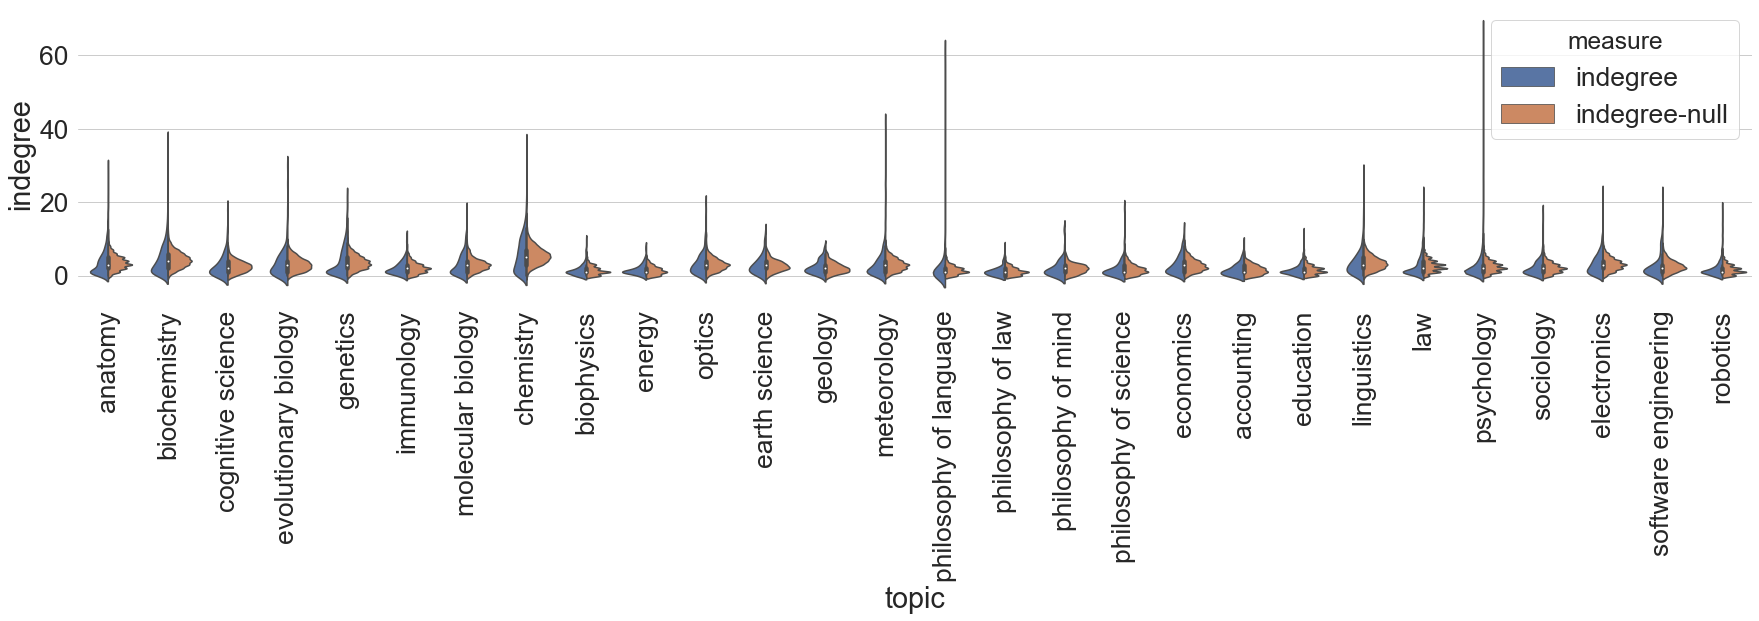

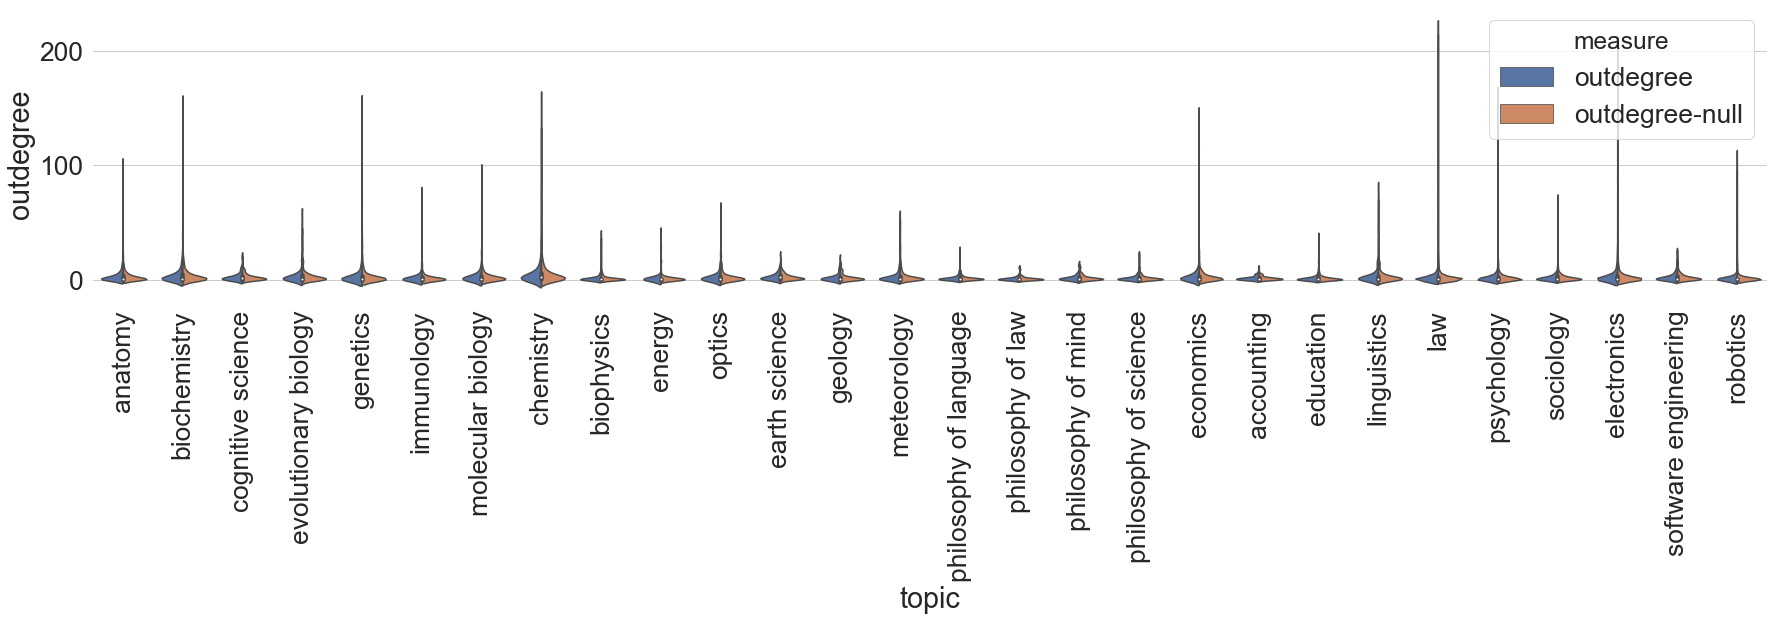

In [ ]:
save_dir = None
for stat in ['indegree', 'outdegree', 'clustering', 'centrality', 'path-length']:
    f, ax = plt.subplots(figsize=(30, 6))
    sns.violinplot(data=df_expand[(df_expand.measure==stat) |\
                                  (df_expand.measure==stat+'-null')],
                   x='topic', y='value', hue='measure', split=True)
    plt.xticks(np.arange(len(topics)), topics, rotation='vertical')
    plt.ylabel(stat)
    plt.subplots_adjust(bottom=0.2)
    sns.despine(left=True, bottom=True)
    if save_dir:
        plt.savefig(save_dir, dpi=300)

In [ ]:
save_dir = None
for stat in ['coreness', 'modularity', 'char-path-length']:
    f, ax = plt.subplots(figsize=(30, 6))
    sns.scatterplot(data=df_expand[(df_expand.measure==stat) |\
                                   (df_expand.measure==stat+'-null')],
                    x='topic', y='value', hue='measure')
    plt.xticks(np.arange(len(topics)), topics, rotation='vertical')
    plt.ylabel(stat)
    plt.subplots_adjust(bottom=0.2)
    sns.despine(left=True, bottom=True)
    if save_dir:
        plt.savefig(path_saved + stat, dpi=300)

### Measures in growing networks